<a href="https://colab.research.google.com/github/morokhalid16/Fraud-detection/blob/main/Fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 999

# Data extraction and  preprocessing

In [14]:
def extract(path_credit, path_target):
    df = pd.read_csv(path_credit, sep=';')
    print('df shape: ', df.shape)
    target = pd.read_csv(path_target, sep=';')
    print('target shape: ', target.shape)
    # merge with target column
    df = df.merge(target, how='left', on='applicationReference')
    return df
path_credit = '/content/sample_data/credit_applications.csv'
path_target = '/content/sample_data/target.csv'
df = extract(path_credit, path_target)

df shape:  (31913, 52)
target shape:  (7483, 2)


In [23]:
#Preprocessing
df['isFraud'] = np.where(df['isFraud'] == True, 1, 0)
df.rename(columns=lambda x: x.replace('s$',''), inplace=True)
df.rename(columns={'d$income':'income', 'd$vehicleAgeMonths':'vehicleAgeMonths', 'd$borrowerCharges':'borrowerCharges'}, inplace=True)
df['hasAddOns'] = np.where(df['hasAddOns'], 1, 0)

In [24]:
df['isFraud'].value_counts()

0    28239
1     3674
Name: isFraud, dtype: int64

In [25]:
(df.isna().sum()/len(df)) * 100 

creationDatetime                      0.000000
creditProduct                         0.000000
requestedAmount                       0.000000
status                                0.000000
statusUpdateDatetime                  0.000000
initialCreditDurationMonths           0.000000
profile                               0.000000
rejectionReason                      90.420832
hasAddOns                             0.000000
projectCategory                       0.000000
projectAmount                         0.000000
interestRate                          0.000000
bankCode                             15.896343
bankAccountId                         9.673174
monthlyPayment                        0.000000
borrowerReference                     0.000000
borrowerCreationDate                  0.000000
borrowerPayslipNetSalary              0.000000
borrowerMaritalStatus                 0.000000
borrowerPhoneAreaCode                42.459186
borrowerPhoneProvider               100.000000
borrowerEmplo

In [26]:
df[df['rejectionReason'] == 'FRAUD_ATTEMPT']['isFraud'].value_counts()  # drop rejectionReason column bceause hightly correlated with isFraud

1    3044
Name: isFraud, dtype: int64

In [27]:
to_drop = ['status', 'statusUpdateDatetime', 'rejectionReason', 'bankCode', 'bankAccountId', 
           'borrowerWorkplaceZipCode',
           'applicationReference', 'borrowerReference',
           'borrowerPhoneAreaCode', 'borrowerPhoneProvider',
           'borrowerEmploymentStartDate',
           'borrowerEmploymentContractType', 'borrowerProfessionalSector', 'sellerCreationDate', 'sellerReference', 'gestionDate']


In [28]:
coBorrowerCols = ['coBorrowerReference',                 
                  'coBorrowerCreationDate',               
                  'coBorrowerPayslipNetSalary',         
                  'coBorrowerMaritalStatus',             
                  'coBorrowerPhoneAreaCode',           
                  'coBorrowerPhoneProvider',         
                  'coBorrowerEmploymentStartDate',      
                  'coBorrowerEmploymentContractType',   
                  'coBorrowerBirthDate',                
                  'coBorrowerProfessionalCategory' ]  
cols= to_drop + coBorrowerCols  

In [29]:
df_int = df.drop(columns=cols, axis= 1)

In [30]:
(df_int.isna().sum()/len(df)) * 100 

creationDatetime                0.000000
creditProduct                   0.000000
requestedAmount                 0.000000
initialCreditDurationMonths     0.000000
profile                         0.000000
hasAddOns                       0.000000
projectCategory                 0.000000
projectAmount                   0.000000
interestRate                    0.000000
monthlyPayment                  0.000000
borrowerCreationDate            0.000000
borrowerPayslipNetSalary        0.000000
borrowerMaritalStatus           0.000000
borrowerBirthDate               0.987059
borrowerProfessionalCategory    0.000000
residenceOwnership              0.000000
income                          0.000000
dealershipReference             0.003134
supplierZipCode                 1.541691
borrowerCharges                 0.003134
vehicleBrand                    0.003134
vehicleModel                    0.012534
vehicleAgeMonths                0.003134
customerTrust                   0.018801
residenceMoveInD

# Feature engineering

In [33]:
#check if a borowwer has a coborowwer
df_int['has_coborowwer'] = np.where(df['coBorrowerReference'].isna(), 0, 1)
#compute age
df_int.dropna(inplace =True) #before that, drop na rows from df_int
from datetime import datetime, date
df_int['borrowerBirthDate'] = pd.to_datetime(df_int['borrowerBirthDate'])
def from_birthdate_to_age(born_date):
    today = date.today()
    return today.year - born_date.year - ((today.month, today.day) < (born_date.month, born_date.day))

df_int['age'] = (df_int['borrowerBirthDate'].apply(lambda x: int(from_birthdate_to_age(x))))

# EDA

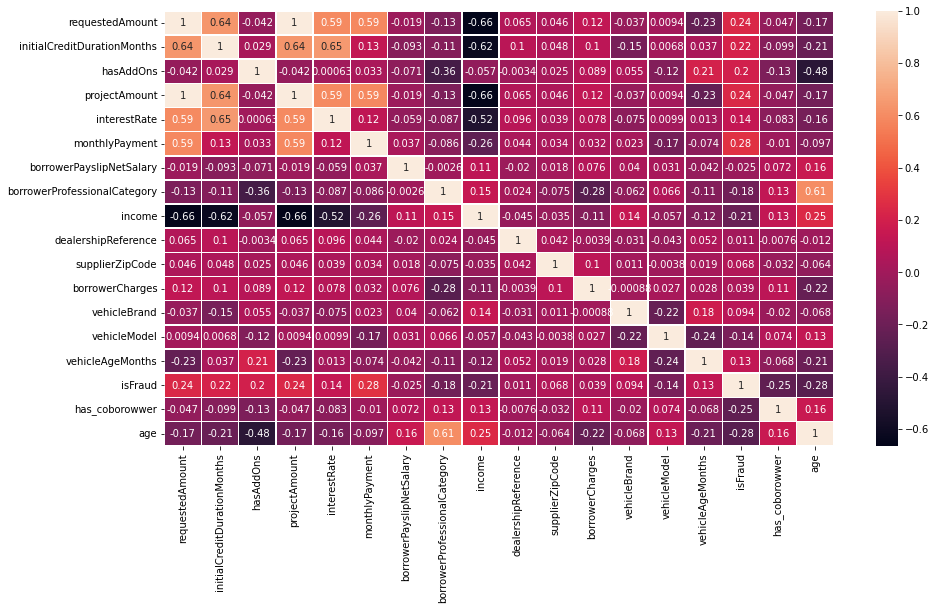

In [34]:
corrMatrix = df_int.corr()
fig, ax = plt.subplots(figsize=(15,8))         # Sample figsize in inches
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)
plt.show()



In [35]:
# delete projectAmount because corr = 1 with requested amount
df_int.drop('projectAmount', axis=1, inplace=True)

In [36]:
cat_cols = df_int.select_dtypes(include='object').columns.tolist()
cat_cols

['creationDatetime',
 'creditProduct',
 'profile',
 'projectCategory',
 'borrowerCreationDate',
 'borrowerMaritalStatus',
 'residenceOwnership',
 'customerTrust',
 'residenceMoveInDate',
 'bankAccountOpeningDate']

In [37]:
dates = ['creationDatetime', 'borrowerCreationDate', 'borrowerBirthDate', 'residenceMoveInDate', 'bankAccountOpeningDate', 'borrowerBirthDate']
not_dates = ['borrowerMaritalStatus', "projectCategory", "residenceOwnership", "customerTrust"]

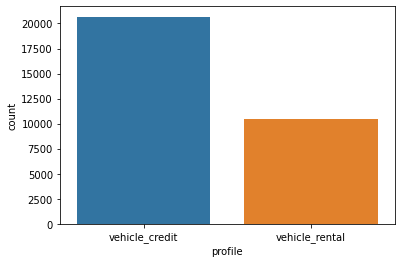

In [38]:
sns.countplot(x="profile", data=df_int)

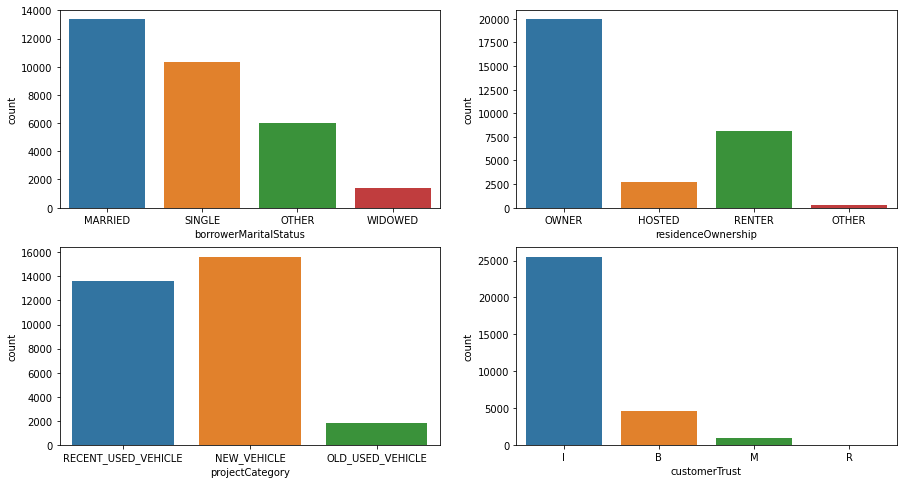

In [39]:
figure, axes = plt.subplots(2, 2, figsize=(15,8))
sns.countplot(x="borrowerMaritalStatus", data=df_int, ax=axes[0,0])
sns.countplot(x="projectCategory", data=df_int, ax=axes[1,0])
sns.countplot(x="residenceOwnership", data=df_int, ax=axes[0,1])
sns.countplot(x="customerTrust", data=df_int, ax=axes[1,1])

# Modeling

In [40]:
y, X = df_int['isFraud'], df_int.drop(dates+['isFraud'], axis=1)
print(' X shape: ', X.shape)


 X shape:  (31091, 22)


In [ ]:
pip install --upgrade category_encoders

In [44]:
def encoding(X, y):
  import category_encoders as ce
  # Define catboost encoder
  cbe_encoder = ce.cat_boost.CatBoostEncoder()
  # Fit encoder and transform the features
  cbe_encoder.fit(X, y)
  X_encoded = cbe_encoder.transform(X)
  return X_encoded
X_encoded = encoding(X, y)
print(' X_encoded shape: ', X_encoded.shape)

 X_encoded shape:  (31091, 22)


In [45]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_encoded)
X_final = pd.DataFrame(X_scaled, columns=list(X.columns))
X_final.head(3)

,creditProduct,requestedAmount,initialCreditDurationMonths,profile,hasAddOns,projectCategory,interestRate,monthlyPayment,borrowerPayslipNetSalary,borrowerMaritalStatus,borrowerProfessionalCategory,residenceOwnership,income,dealershipReference,supplierZipCode,borrowerCharges,vehicleBrand,vehicleModel,vehicleAgeMonths,customerTrust,has_coborowwer,age
0,0.708768,-1.471931,-1.827564,0.710299,-0.692181,0.926326,-1.605570,-0.473085,0.497354,-0.829846,1.238218,-0.743334,2.599311,-1.123987,-1.370690,-0.678716,0.644353,-0.364053,-0.307799,0.443282,0.998425,0.763443
1,0.708768,-1.471931,-1.827564,0.710299,1.444708,0.926326,-1.591956,-0.451430,-0.474198,1.391869,-0.521745,1.242614,2.314270,-0.300602,-0.249606,-0.678716,0.644353,0.358840,0.272223,0.443282,-1.001577,-1.239489
2,0.708768,-1.471931,-1.827564,0.710299,1.444708,-0.984528,-1.605570,-0.418478,-0.420962,-0.829846,-0.521745,-0.743334,4.678684,-0.751712,-0.811858,-0.678716,0.644353,-0.318300,-0.709353,0.443282,0.998425,-0.207676


In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.33, random_state=42)

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
lr = LogisticRegression(random_state=0)
rf = RandomForestClassifier(random_state=0)
gbc = GradientBoostingClassifier(random_state=0)

In [60]:
models = {'lr' : lr, 'rf' : rf, 'gbc': gbc }
def get_key(val):
    for key, value in models.items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [61]:
##########################Training###################################

lr = lr.fit(X_train, y_train)
rf = rf.fit(X_train, y_train)
gbc = gbc.fit(X_train, y_train)


In [62]:
def classification_report(model, X_test, y_test, seuil=.5):
  from sklearn.metrics import confusion_matrix
  from sklearn import  metrics
  y_pred_prob = model.predict_proba(X_test)
  y_pred = (y_pred_prob[:,0] <= 0.5) * 1
  cm = confusion_matrix(y_test, y_pred)
  print("Confusion matrix: \n ", cm)
  precision = metrics.precision_score(y_test, y_pred)
  recall = metrics.recall_score(y_test, y_pred)
  f1_score = metrics.f1_score(y_test, y_pred)
  perf = pd.DataFrame({'model_name':[get_key(model)] , 'precision':[precision], 'recall':[recall], 'f1_score':[f1_score]})
  print("\n \n")
  print(perf)
  print("\n \n")
  metrics.plot_roc_curve(model, X_test, y_test)
  plt.show()
  print("\n \n")



lr
Confusion matrix: 
  [[9143  161]
 [ 481  476]]

 

  model_name  precision    recall  f1_score
0         lr   0.747253  0.497388   0.59724

 



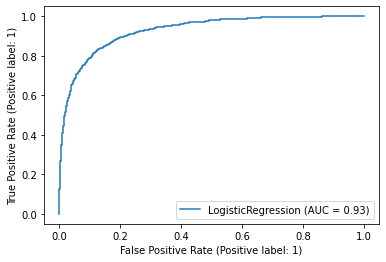


 

rf
Confusion matrix: 
  [[9191  113]
 [ 511  446]]

 

  model_name  precision   recall  f1_score
0         rf   0.797853  0.46604  0.588391

 



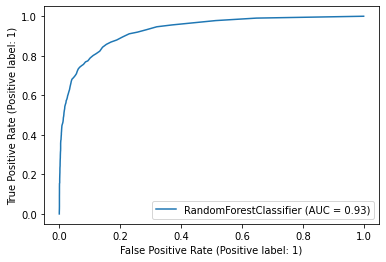


 

gbc
Confusion matrix: 
  [[9156  148]
 [ 463  494]]

 

  model_name  precision    recall  f1_score
0        gbc    0.76947  0.516196  0.617886

 



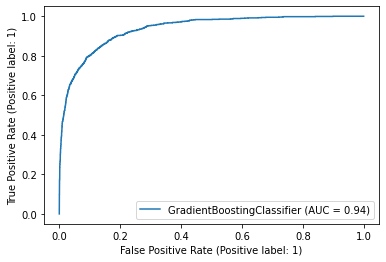

In [63]:
for m in models.keys():
  print(m)
  classification_report(models[m], X_test, y_test)


# Model optimization : Fine tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

n_estimators = [200, 500, 1000]
learn_rates = [0.02, 0.05]
max_depths = [2, 5, 7]
min_samples_leaf = [5,10]
min_samples_split = [5,10]

param_grid = {'n_estimators': n_estimators,
              'learning_rate': learn_rates,
              'max_depth': max_depths,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split}


grid_search = GridSearchCV(models['gbc'], param_grid, cv=5, verbose=0, n_jobs=-1)

grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_